### Justin Butler
### Population Project
### USA Data

a = 0.0196230740592 b = 6.16059095632
popt = [  3.27783072e+02   1.36356320e-02] pcov = [[  5.87830706e+01   2.53479005e-03]
 [  2.53479005e-03   2.45802426e-07]]
lopt = [  3.03819040e+02   2.07764275e-02   4.86475571e+02] lcov = [[  1.45684658e+01  -1.57843979e-03   9.98381717e+01]
 [ -1.57843979e-03   7.72824169e-07  -2.82118134e-02]
 [  9.98381717e+01  -2.82118134e-02   1.22949550e+03]]
lopt = [  3.03819040e+02   2.07764275e-02   4.86475571e+02]
lcov = [[  1.45684658e+01  -1.57843979e-03   9.98381717e+01]
 [ -1.57843979e-03   7.72824169e-07  -2.82118134e-02]
 [  9.98381717e+01  -2.82118134e-02   1.22949550e+03]]


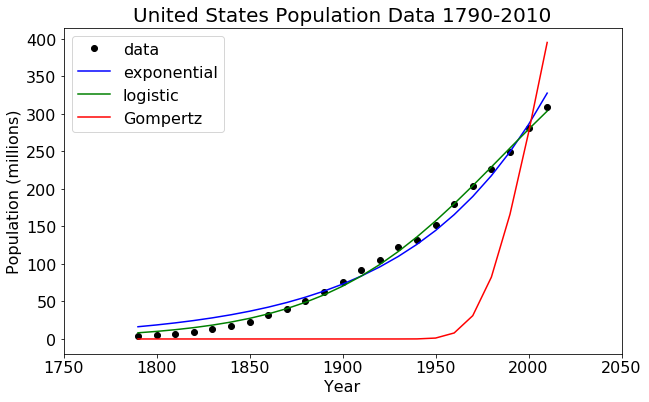

In [15]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#--------------------------------------------------
# Read and scale US Population Data.
#--------------------------------------------------
CensusFile = open('USPopulation.csv', 'r') #Don't you dare overwrite this file!
N = 23 # number of data points
i = 0
j = 0
USYears = np.zeros([N], dtype=int)
USPop0 = np.zeros([N], dtype=int)
for line in CensusFile:
    if i == 0 or i==1:
        i=i+1
    else:
        values = line.split(',')
        USYears[j] = int(values[0])
        USPop0[j] = int(values[1])
        j = j+1
        i = i+1

CensusFile.close()
USPop = USPop0/1.e6 #population as a floating point number in millions

#----------------------------------
# Find the PPGR and PolyFit values
#----------------------------------

#Declare the array to store my PPGR values
M = N-2 #number of data points - since the two end points aren't between two points
PPGR = np.zeros([M])

#This for loop will find the PPGR between any two points with one point between them.
for k in range(21):
    PPGR[k] =  (1/USPop[k+1])*((USPop[k+2]-USPop[k])/(USYears[k+2]-USYears[k]))
    k = k+1

#Caluculate the average of all of the values just generated
avgPPGR = np.average(PPGR)

#Time to start making the best fit line. First we will use np.polyfit to find the slope and y-intercept of the line
USPopLineCoef = np.polyfit(USPop[1:N-1],PPGR,1)

#If something seems weird, uncomment the next line to view the line coefficients
#print (USPopLineCoef)

#Next, I will use the values of USPop as my x-values for a function of the best fit line
USPopLine = USPopLineCoef[0]*USPop + USPopLineCoef[1]


#------------------------------------------------------------------------------------------
# Time to make the functions of our models
#------------------------------------------------------------------------------------------

#Exponential model
def US_exp(t,P0,r):
    P = P0*np.exp(r*t)
    return P

#Calculating L and r (estimates) for logistic model
#L = (-USPopLineCoef[1])/USPopLineCoef[0]
#r = USPopLineCoef[1]

#Logistic Model
def US_log(t,P0,r,L):
    A = ((L-P0)/P0)
    T = L
    B = 1 + A*np.exp(-r*t)
    return T/B

#Gompertz Model
def US_Gomp(t,P0,r,L):
    r = avgPPGR/(-(P0/L)+1)
    log = np.log(L/P0)
    exp = -log*np.exp(-r*t)
    return L*np.exp(exp)

#---------------------------------
# Population graph
#---------------------------------

#plt.figure(figsize=(8,6))
#plt.rc('xtick', labelsize=16) 
#plt.rc('ytick', labelsize=16)
#
#plt.plot(USYears, USPop, 'o', color='b', label='data')
#plt.ylabel('Population (millions)', fontsize=16)
#plt.xlabel('Year', fontsize=16)
#plt.title('United States Population Data 1790-2010', fontsize=20)
#plt.legend(loc=2, fontsize=16)
#plt.xlim([1750, 2050])
#plt.savefig('USPopData.png')
#plt.show()
#plt.close()

#----------------------
# Optimize Exponential
#----------------------

#------- Approximate parameter values for Exponential model ------
a,b = np.polyfit(USYears-2010,np.log(USPop),1)
print "a =", a,"b =", b

r_exp_lin = a
P0_exp_lin = np.exp(b)

#------- Take estimate and create the model -------------

popt, pcov = curve_fit(US_exp, USYears-2010, USPop, p0=(P0_exp_lin,r_exp_lin))
print "popt =", popt, "pcov =", pcov

P_0exp = popt[0]
r_exp = popt[1]
P_exp = US_exp(USYears-2010, P_0exp, r_exp)

#----------------------
# Optimize Logistic
#----------------------

#------- Approximate paramater values for Logistic model ---------



#------- Take estimate and create logistic
lopt, lcov = curve_fit(US_log, USYears-2010, USPop, p0=(USPop[22],avgPPGR,400))
print "lopt =", lopt, "lcov =", lcov

P_0log = lopt[0]
r_log = lopt[1]
L_log = lopt[2]
P_log = US_log(USYears-2010, P_0log, r_log, L_log)

#----------------------
# Optimize Gompertz
#----------------------
gopt, gcov = curve_fit(US_Gomp, USYears-2010, USPop, p0=(USPop[22], avgPPGR,400))
print "lopt =", lopt
print "lcov =", lcov

P_0gomp = gopt[0]
r_gomp = gopt[1]
L_gomp = gopt[2]
P_gomp = US_Gomp(USYears-2010, P_0gomp, r_gomp, L_gomp) 

#------------------------
# Plotting the Graphs
#------------------------

plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
#Plotting the data points
plt.plot(USYears, USPop, 'o', color='k', label='data')
#First, draw the exponential model,
plt.plot(USYears, P_exp, color='b', label='exponential')
#then the logistic model,
plt.plot(USYears, P_log, color='g', label="logistic")
#and finally Gompertz model.
plt.plot(USYears, P_gomp, color='r', label = 'Gompertz')
plt.ylabel('Population (millions)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('United States Population Data 1790-2010', fontsize=20)
plt.legend(loc=2, fontsize=16)
#plt.xlim([-250, 10])
plt.xlim([1750, 2050])
plt.savefig('USPopData.png')
plt.show()
plt.close()
